# Imports

In [1]:
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
import emcee
import numpy as np
from scipy.integrate import simpson, quad
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import corner
#import cmyt
import cmasher

In [2]:
from lensing.funcs import normalize_cov

# functions

In [3]:
def chi_red(ajuste,data,err,gl):
	'''
	Reduced chi**2
	------------------------------------------------------------------
	INPUT:
	ajuste       (float or array of floats) fitted value/s
	data         (float or array of floats) data used for fitting
	err          (float or array of floats) error in data
	gl           (float) grade of freedom (number of fitted variables)
	------------------------------------------------------------------
	OUTPUT:
	chi          (float) Reduced chi**2
	'''

	BIN=len(data)
	chi=((((ajuste-data)**2)/(err**2)).sum())/float(BIN-1-gl)
	return chi

In [4]:
def rho_mean(z):
    '''densidad media en Msun/(pc**2 Mpc)'''
    global cosmo
    p_cr0 = cosmo.critical_density(0).to('Msun/(pc**2 Mpc)').value
    a = cosmo.scale_factor(z)
    out = p_cr0*cosmo.Om0/a**3
    return out

In [5]:
def plot_mcmc_mLW(ndim, sampler):
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = [
        '$r_s$',
        '$\delta_c$',
        '$\delta_2$',
        'off',
             # 'rv2',f'$r_s2$',f'$a2$', f'$b2$',f'$\delta2$',
             ]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

    flat_samples = sampler.get_chain(discard=int(0.1*len(samples)), thin=1, flat=True)
    print(flat_samples.shape, flush=True)

    rs = np.percentile(flat_samples[:,0], [16, 50, 84])
    dc = np.percentile(flat_samples[:,1], [16, 50, 84])
    d2  = np.percentile(flat_samples[:,2], [16, 50, 84])
    off = np.percentile(flat_samples[:,3], [16, 50, 84])
    #dc = np.percentile(flat_samples[:,4], [16, 50, 84])

    fig = corner.corner(
        flat_samples, labels=labels,
        bins=50,
        # truths=[rv[0],rs[0],a[0],b[0],dc[0]],
        smooth=2.
    );
    return np.vstack([rs, dc,d2, off]), flat_samples



In [6]:
def plot_chains(ndim, sampler, trow=0.5, color='k', axes=None):
    if axes is None:
        fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    
    samples = sampler.get_chain()
    labels = [
        'dc', 'rs', 'a', 'b', 'off'
    ]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], color, alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

    flat_samples = sampler.get_chain(discard=int(trow*len(samples)), thin=1, flat=True)
    print(flat_samples.shape, flush=True)

    return axes

In [7]:
def plot_mcmc_contours(ndim, sampler, trow=0.5, color='k', fig=None):
    
    samples = sampler.get_chain()
    labels = [
        'dc', 'rs', 'a', 'b', 'off'
    ]
    flat_samples = sampler.get_chain(discard=int(trow*len(samples)), thin=1, flat=True)
    print(flat_samples.shape, flush=True)

    if fig is None:
        fig = corner.corner(
            flat_samples, labels=labels,
            bins=50,
            # truths=[rv[0],rs[0],a[0],b[0],dc[0]],
            smooth=2.,
            color=color
        );
    else:
        corner.corner(
            flat_samples, labels=labels,
            fig=fig,
            bins=50,
            # truths=[rv[0],rs[0],a[0],b[0],dc[0]],
            smooth=2.,
            color=color
        );
    return fig

# classes & models

In [8]:
class Likelihood:

    def __init__(self, func, r, y, yerr, limits, redshift):
        self.func = func
        self.r = r
        self.y = y
        self.yerr = yerr
        self.params = list(limits.keys())
        self.limits = limits
        self.rhomean = rho_mean(redshift)

    def log_likelihood(self, theta):
        model = self.func(self.r, *theta)*self.rhomean
        dist = self.y - model
        #return -0.5*np.dot(dist, np.dot(self.yerr, dist))
        return -0.5 * np.sum(((self.y - model)**2 )/self.yerr**2)

    def log_prior(self, theta):
        ### tener cuidado con el orden de lims!
        if np.prod(
            [self.limits[self.params[j]][0] < theta[j] < self.limits[self.params[j]][1] for j in range(len(self.params))],
            dtype=bool
        ): return 0
        return -np.inf

    def log_probability(self, theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta)

In [9]:
class Profile:

    def sigma(self, R, *params):
        chi = np.linspace(0.001, 200.0, 1000)
        vals = self.model(R[None, :], chi[:,None], *params[:-1])
        return 2.0*simpson(vals, x=chi, axis=0)+params[-1]

    def mean_sigma(self, R, *params):
        x_grid = np.linspace(1e-5, R.max(), 1000)
        f_grid = self.sigma(x_grid, *params)
        F_vals = np.array([
            simpson(x_grid[x_grid <= Ri] * f_grid[x_grid <= Ri], x=x_grid[x_grid <= Ri])
            for Ri in R
        ])
        return F_vals

    def delta_sigma(self, R, *params):
        anillo = self.sigma(R, *params)
        disco = self.mean_sigma(R, *params)
        return (2 / R**2) * disco - anillo

In [10]:
class HSW(Profile):
    def __init__(self):
        super().__init__()
        self.nparams = 4
        self.limits_S = {'dc':(-0.99,-0.01), 'rs':(0.5,5.0), 'a':(1.01,9.99), 'b':(1.01,14.99), 'off':(-0.5,0.5)}
        self.limits_DSt = {'dc':(-0.99,-0.01), 'rs':(0.5,5.0), 'a':(1.01,9.99), 'b':(1.01,14.99)}

    def model(self, R, chi, dc, rs, a, b):
        r = np.hypot(R, chi)
        return dc*(1-(r/rs)**a)/(1+r**b)

In [11]:
class HSWfixed(Profile):
    def __init__(self):
        super().__init__()
        self.nparams = 4
        #self.limits_S = {'dc':(-0.99,-0.01), 'rs':(0.1,1.99), 'a':(1.01,9.99), 'b':(1.01,14.99), 'off':(-0.5,0.5)}
        #self.limits_DSt = {'dc':(-0.99,-0.01), 'rs':(0.1,1.99), 'a':(1.01,9.99), 'b':(1.01,14.99)}
        self.limits_S = {'rs':(0.5,1.99), 'off':(-0.5,0.5)}
        self.limits_DSt = {'rs':(0.1,1.99)}

    def model(self, R, chi, rs):
        dc = -3.7 + 3.4*rs
        a = 230.9 - 548.4*rs + 326.6*rs**2
        b = 194.1 - 454.7*rs + 273.4*rs**2

        r = np.hypot(R, chi)

        num = 1.0 - np.exp(np.clip(a * np.log(r/rs), -700, 700))
        den = 1.0 + np.exp(np.clip(b * np.log(r), -700, 700))
    
        return dc * num / den

In [12]:
class ModLW(Profile):
    def __init__(self):
        super().__init__()
        self.limits_S = {'rs':(0.80,2.0), 'dc':(-1.0,0.0), 'd2':(-0.99,0.9), 'off':(-0.5,0.5)}

    def model(self, R, chi, rs, dc, d2):
        r = np.hypot(R, chi)
        rv = 1.0
        return np.where(r < rv, dc+(d2-dc)*(r/rv)**3, np.where(r > rs, 0.0, d2))

In [13]:
class modifiedLW:
    def __init__(self):
        self.nparams = 3
        self.limits_S = {'rs':(0.20,2.0), 'dc':(-1.0,0.0), 'd2':(-0.99,0.9), 'off':(-1.0,1.0)}
        self.limits_DSt = {'rs':(1.0,2.0), 'dc':(-1.0,0.0), 'd2':(-0.5,0.5)}

    def model(r, rv, rs, dc, d2):
        '''
        modified Lavaux-Wandelt model. (arXiv:1110.0345)
        '''
        return np.where(r < rv, dc+(d2-dc)*(r/rv)**3, np.where(r > rs, 0.0, d2))

    def sigma(self, R, rs, dc, d2, off):
        Rv = 1.
        sq_diff = lambda r,r2: np.sqrt(np.abs(r2**2 - r**2))
        argument = lambda r,rv: np.sqrt(np.abs((rv/r)**2 - 1))
        den_integrada = 2*np.where(
            R<Rv,
            dc*sq_diff(R,rs) + (d2-dc)*(sq_diff(R,Rv)*(5/8*(R/Rv)**2 - 1) + sq_diff(R,rs) + 3/8*(R**4/Rv**3)*np.arcsinh(argument(R,Rv))),
            np.where(
                R>rs,
                0.0,
                d2*sq_diff(R,rs)
            )
        )
        sigma = den_integrada/Rv + off
        return sigma

    def mean_sigma(self, R_vals, rs, dc, d2, off):
        x_grid = np.linspace(1e-6, 1.1*R_vals.max(), 1000)
        f_grid = self.sigma(x_grid, rs, dc, d2, off)
        F_vals = np.array([
            simpson(x_grid[x_grid <= R] * f_grid[x_grid <= R], x=x_grid[x_grid <= R])
            for R in R_vals
        ])
        return F_vals

    def delta_sigma(self, R, rs, dc, d2, off):
        anillo = self.sigma(R, rs, dc, d2, off)
        disco = self.mean_sigma(R, rs, dc, d2, off)
        return (2.0 / R**2) * disco - anillo

# cttes & files

In [36]:
#PROFILE_PATH = '/content/drive/MyDrive/IATE/DGLFest2025/Rv08-30/'
PROFILE_PATH = 'lensing/results/Rv07-30/'
GRAV = ['GR', 'fR']
VOIDTYPE = ['S', 'R']
zmin, zmax = 0.1, 0.6
dz = 0.05
nz = int((zmax-zmin)/dz)
zrange = np.linspace(zmin, zmax, nz+1)
REDSHIFT = [f'0{100*zrange[i]:1.0f}-0{100*zrange[i+1]:1.0f}' for i in range(nz)]
#MISSING_Z = ['030-035', '035-040', '040-045', '045-050']
MISSING_Z = []

In [37]:
print(REDSHIFT)

['010-015', '015-020', '020-025', '025-030', '030-035', '035-040', '040-045', '045-050', '050-055', '055-060']


In [38]:
Sigma = {}
DSigma_t = {}
DSigma_x = {}

covS = {}
covDSt = {}
covDSx = {}

R = {}

Nvoids = {}
MEANZ = {}

for g in GRAV:
    Sigma[g] = {}
    DSigma_t[g] = {}
    DSigma_x[g] = {}

    covS[g] = {}
    covDSt[g] = {}
    covDSx[g] = {}

    R[g] = {}
    Nvoids[g] = {}
    MEANZ[g] = {}

    for z in REDSHIFT:
        if z in MISSING_Z: continue
        Sigma[g][z] = {}
        DSigma_t[g][z] = {}
        DSigma_x[g][z] = {}

        covS[g][z] = {}
        covDSt[g][z] = {}
        covDSx[g][z] = {}

        R[g][z] = {}
        Nvoids[g][z] = {}
        MEANZ[g][z] = {}

        for t in VOIDTYPE:
            filename = PROFILE_PATH+f'lensing_fullsource-{g}_L09_Rv07-30_z{z}_type{t}_binlin.fits'
            try:
                with fits.open(filename) as f:
                    R[g][z][t] = np.linspace(f[0].header['RIN'],f[0].header['ROUT'],f[0].header['N'])
                    Nvoids[g][z][t] = f[0].header['NVOIDS']
                    MEANZ[g][z][t] = f[0].header['Z_MEAN']

                    Sigma[g][z][t] = f[1].data.Sigma
                    DSigma_t[g][z][t] = f[1].data.DSigma_t
                    DSigma_x[g][z][t] = f[1].data.DSigma_x

                    covS[g][z][t] = f[2].data
                    covDSt[g][z][t] = f[3].data
                    covDSx[g][z][t] = f[4].data
            except FileNotFoundError:
                print(f"file {filename} not found")
                continue

# MCMC

In [14]:
#NCORES = 4
NCORES = 128
print(NCORES)
NWalkers = 32
# ndim = len(l.params)
NIT = 1000
sample = 'TEST'

128


In [34]:
pos_mlw = np.array([
    np.random.uniform(0.85,1.5,NWalkers),
    np.random.uniform(-0.9,-0.1,NWalkers),
    np.random.uniform(-0.8,0.5,NWalkers),
    #np.random.uniform(4.5,9.0,nwalkers),
    np.random.uniform(-0.1,0.1,NWalkers),
]).T

pos_hsw = np.array([
    np.random.uniform(-0.9,-0.1,NWalkers),
    np.random.uniform(0.5,1.8,NWalkers),
    np.random.uniform(1.0,9.0,NWalkers),
    np.random.uniform(3.0,14.0,NWalkers),
    np.random.uniform(-0.45,0.45,NWalkers),
]).T

pos_hswf = np.array([
    #np.random.uniform(-0.9,-0.1,NWalkers),
    np.random.uniform(0.5,1.8,NWalkers),
    #np.random.uniform(1.0,9.0,NWalkers),
    #np.random.uniform(3.0,14.0,NWalkers),
    np.random.uniform(-0.45,0.45,NWalkers),
]).T

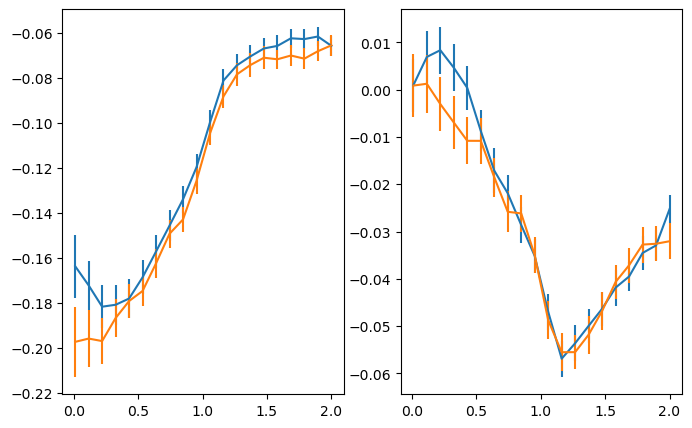

In [40]:
#g = 'GR'
z = '030-035'
t = 'R'

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5), sharex=True)
for g in GRAV:
    ax1.errorbar(R[g][z][t], Sigma[g][z][t], np.sqrt(np.diag(covS[g][z][t])))
    ax2.errorbar(R[g][z][t], DSigma_t[g][z][t], np.sqrt(np.diag(covDSt[g][z][t])))

Text(0.5, 1.0, '$\\Sigma_c \\gamma_{\\times}$')

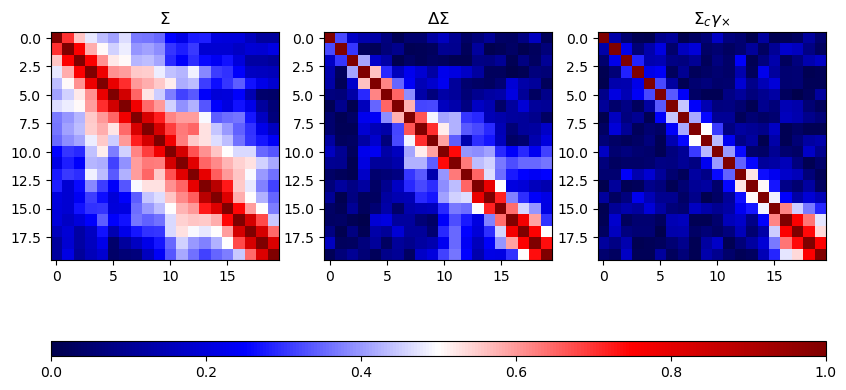

In [41]:
#colormap = 'RdYlGn_r'
colormap = 'seismic'
fig, axes = plt.subplots(1,3,figsize=(10,7), sharex=True)
cmp = axes[0].imshow(normalize_cov(np.abs(covS[g][z][t])), vmin=0, vmax=1, cmap=colormap)
axes[1].imshow(normalize_cov(np.abs(covDSt[g][z][t])), vmin=0, vmax=1, cmap=colormap)
axes[2].imshow(normalize_cov(np.abs(covDSx[g][z][t])), vmin=0, vmax=1, cmap=colormap)
fig.colorbar(cmp, location='bottom', ax=axes, aspect=50)

axes[0].set_title('$\Sigma$')
axes[1].set_title('$\Delta \Sigma$')
axes[2].set_title('$\Sigma_c \gamma_{\\times}$')

Text(0.5, 1.0, '$\\Sigma_c \\gamma_{\\times}$')

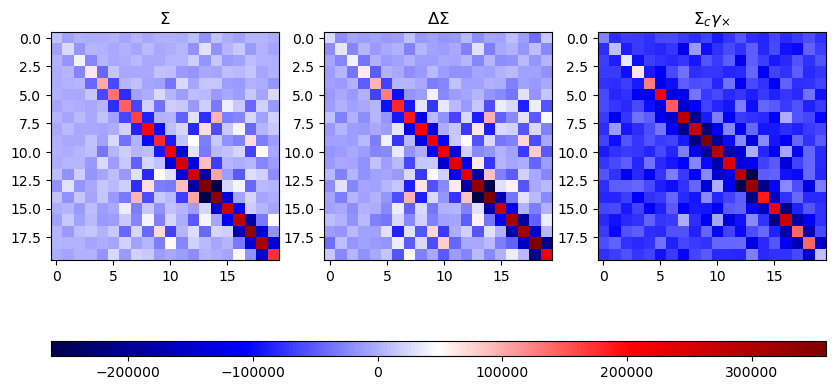

In [44]:
#colormap = 'RdYlGn_r'
colormap = 'seismic'
fig, axes = plt.subplots(1,3,figsize=(10,7), sharex=True)
cmp = axes[0].imshow(np.linalg.inv(covS[g][z][t]), cmap=colormap)
axes[1].imshow(np.linalg.inv(covDSt[g][z][t]), cmap=colormap)
axes[2].imshow(np.linalg.inv(covDSx[g][z][t]), cmap=colormap)
fig.colorbar(cmp, location='bottom', ax=axes, aspect=50)

axes[0].set_title('$\Sigma$')
axes[1].set_title('$\Delta \Sigma$')
axes[2].set_title('$\Sigma_c \gamma_{\\times}$')

In [57]:
fitted_params = {}
error_params = {}
mcmc_samples = {}
sampler_dict = {}

model = HSW()
#model = HSWfixed()

#model = ModLW()
#model = modifiedLW()

start=0
for g in GRAV:
    logL1 = Likelihood(
        func=model.sigma,
        r=R[g][z][t][start:],
        y=Sigma[g][z][t][start:],
        #yerr=np.sqrt(np.diag(covS[g][z][t]))[start:],
        yerr=np.linalg.inv(covS[g][z][t][start:, start:]),
        limits=model.limits_S,
        redshift=MEANZ[g][z][t]
    )
    logL2 = Likelihood(
        func=model.delta_sigma,
        r=R[g][z][t][start:],
        y=DSigma_t[g][z][t][start:],
        #yerr=np.sqrt(np.diag(covDSt[g][z][t]))[start:],
        yerr=np.linalg.inv(covDSt[g][z][t][start:, start:]),
        limits=model.limits_S,
        redshift=MEANZ[g][z][t]
    )
    pu
    def sum_logL(theta):
        return logL1.log_probability(theta)+logL2.log_probability(theta)
    
    with Pool(processes=NCORES) as pool:
        sampler = emcee.EnsembleSampler(
            NWalkers,
            len(logL1.params),
            #logL.log_probability,
            sum_logL,
            pool=pool
        )
        sampler.run_mcmc(
            #pos_mlw, 
            pos_hsw, 
            #pos_hswf, 
            NIT, progress=True
        )
    
    fitted_params[g] = {}
    error_params[g] = {}
    mcmc_samples[g] = sampler.get_chain()
    sampler_dict[g] = sampler
    
    for i,param in enumerate(logL1.params):
        percentil = np.percentile(mcmc_samples[g][int(NIT*0.5),:,i], [16,50,84])
        fitted_params[g][param] = percentil[1]
        error_params[g][param] = tuple(percentil[[0,2]]-percentil[1])
    
    red_chisq = chi_red(logL1.func(logL1.r, *fitted_params[g].values())*logL1.rhomean, logL1.y, logL1.yerr, len(logL1.params))
    print('Reduced chi: '.ljust(10,'.'), red_chisq)
    red_chisq = chi_red(logL2.func(logL2.r, *fitted_params[g].values())*logL2.rhomean, logL2.y, logL2.yerr, len(logL2.params))
    print('Reduced chi: '.ljust(10,'.'), red_chisq)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.31it/s]


Reduced chi:  2.5257321929363098e-09
Reduced chi:  1.9819835575511667e-08


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:04<00:00,  3.28it/s]


Reduced chi:  4.0600601691388826e-08
Reduced chi:  4.805591693330817e-08


In [58]:
fitted_params

{'GR': {'dc': np.float64(-0.5389612869070262),
  'rs': np.float64(4.071977802633956),
  'a': np.float64(6.407865479075131),
  'b': np.float64(7.4457295215459744),
  'off': np.float64(-0.5580085022377042)},
 'fR': {'dc': np.float64(-0.5863188665700079),
  'rs': np.float64(3.71781885374309),
  'a': np.float64(5.26393143532982),
  'b': np.float64(6.8204214927759095),
  'off': np.float64(-0.708171382380983)}}

In [59]:
error_params

{'GR': {'dc': (np.float64(-0.02726527464495143),
   np.float64(0.02056032982988487)),
  'rs': (np.float64(-1.0243354322874878), np.float64(0.7159347652416894)),
  'a': (np.float64(-2.17486933700774), np.float64(1.0716886610177987)),
  'b': (np.float64(-0.8163475137143896), np.float64(0.9797964416385891)),
  'off': (np.float64(-0.05247028686246258), np.float64(0.03824004624464661))},
 'fR': {'dc': (np.float64(-0.02893105891184289),
   np.float64(0.017551764308549878)),
  'rs': (np.float64(-0.6538794776338355), np.float64(0.8497368774796747)),
  'a': (np.float64(-1.513390997552234), np.float64(1.5064594204631643)),
  'b': (np.float64(-0.6850302667292993), np.float64(0.3919485369050264)),
  'off': (np.float64(-0.05803643454875762), np.float64(0.03906702797638151))}}

(16000, 5)
(16000, 5)


array([<Axes: ylabel='dc'>, <Axes: ylabel='rs'>, <Axes: ylabel='a'>,
       <Axes: ylabel='b'>, <Axes: xlabel='step number', ylabel='off'>],
      dtype=object)

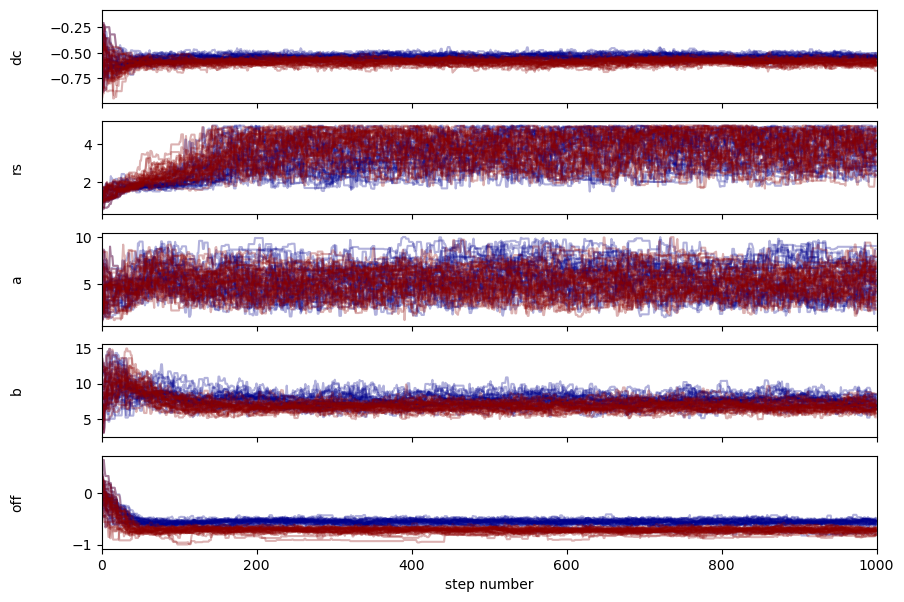

In [60]:
axes = plot_chains(len(logL1.params), sampler_dict['GR'], color='darkblue')
plot_chains(len(logL2.params), sampler_dict['fR'], color='darkred', axes=axes)

(16000, 5)
(16000, 5)


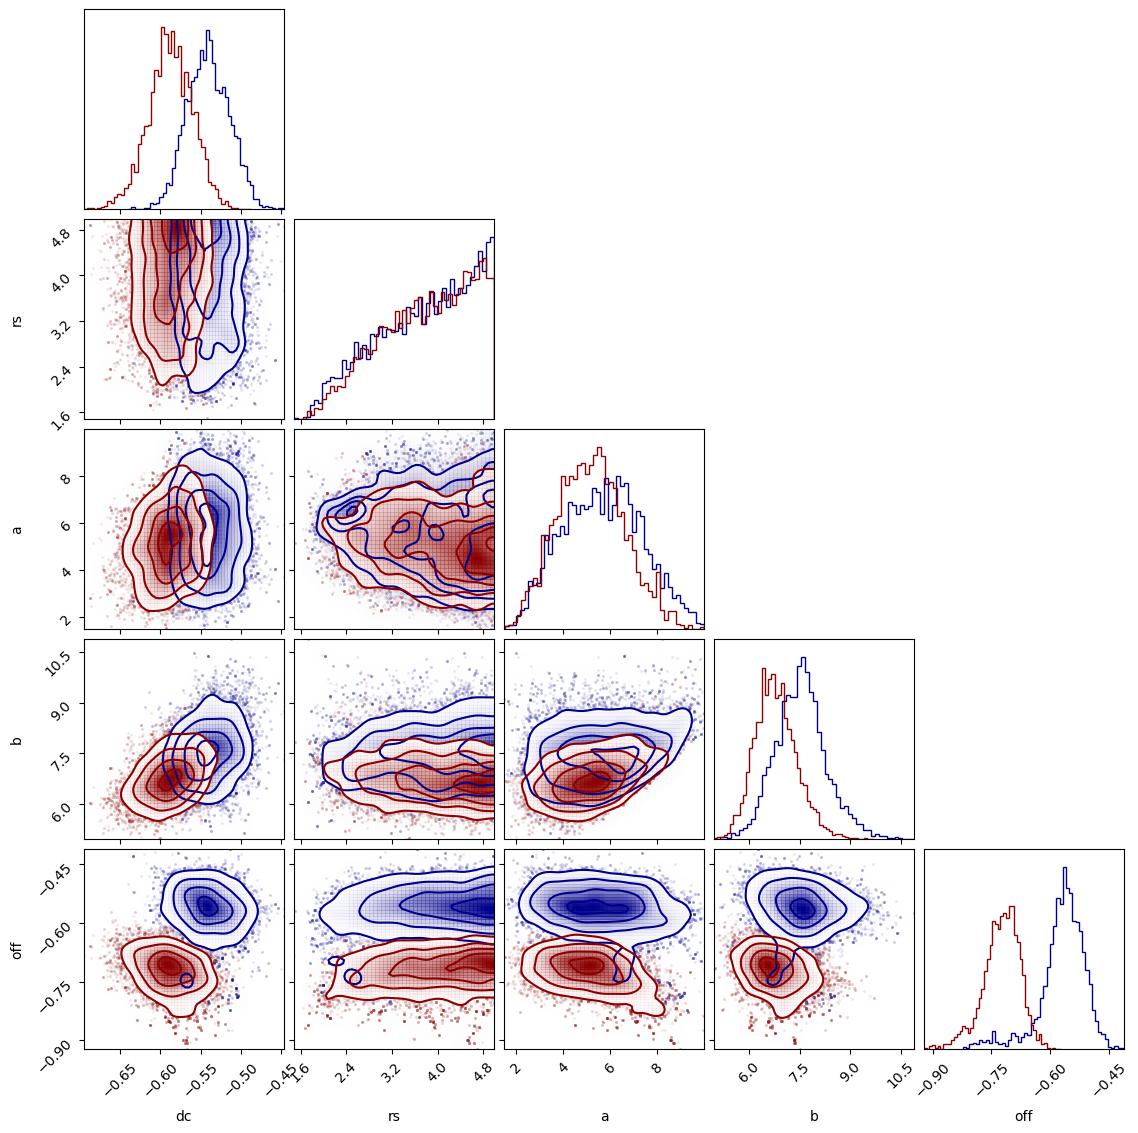

In [61]:
fig = plot_mcmc_contours(len(logL1.params), sampler_dict['GR'], trow=0.5, color='darkblue')
plot_mcmc_contours(len(logL2.params), sampler_dict['fR'], trow=0.5, color='darkred', fig=fig);

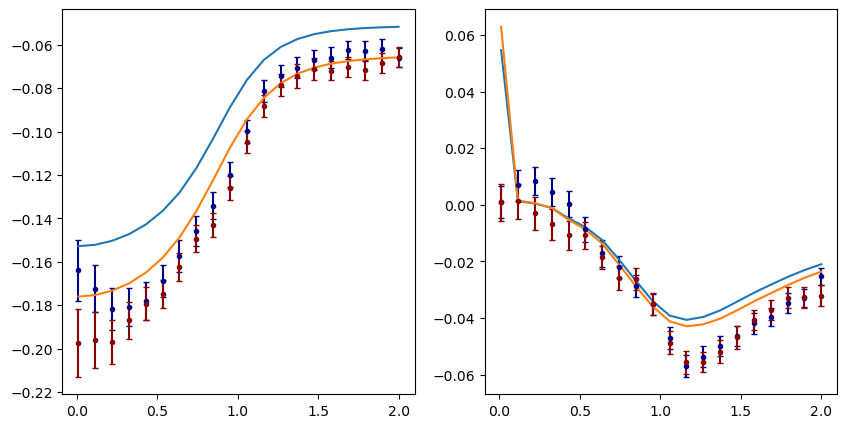

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharex=True)

for g,c in zip(GRAV, ['darkblue', 'darkred']):
    ax1.errorbar(R[g][z][t], Sigma[g][z][t], np.sqrt(np.diag(covS[g][z][t])), fmt='.', capsize=2, color=c)
    #ax1.plot(R[g][z][t][start:], Sigma[g][z][t][start:], '.--')
    ax1.plot(logL1.r, logL1.func(R[g][z][t][start:], *fitted_params[g].values())*rho_mean(MEANZ[g][z][t]))

    ax2.errorbar(R[g][z][t], DSigma_t[g][z][t], np.sqrt(np.diag(covDSt[g][z][t])), fmt='.', capsize=2, color=c)
    #ax1.plot(R[g][z][t][start:], DSigma_t[g][z][t][start:], '.--')
    ax2.plot(logL2.r, logL2.func(R[g][z][t][start:], *fitted_params[g].values())*rho_mean(MEANZ[g][z][t]))

# test voids MICE

In [37]:
PATH = '/home/fcaporaso/profiles/voids/Rv_10-50/lensing_Rv10-50_z02-04_typeall_RMAX5.fits'

In [38]:
MICE = {}
with fits.open(PATH) as f:
    MICE['MEANZ'] = f[0].header['Z_MEAN']
    MICE['R'] = f[1].data.Rp
    MICE['Sigma'] = f[2].data.Sigma.reshape(101,100)[0]
    MICE['DSigma_t'] = f[2].data.DSigma_T.reshape(101,100)[0]
    MICE['covS'] = f[3].data.covS.reshape(100,100)
    MICE['covDSt'] = f[3].data.covDSt.reshape(100,100)
    MICE['covDSx'] = f[3].data.covDSt.reshape(100,100)

<ErrorbarContainer object of 3 artists>

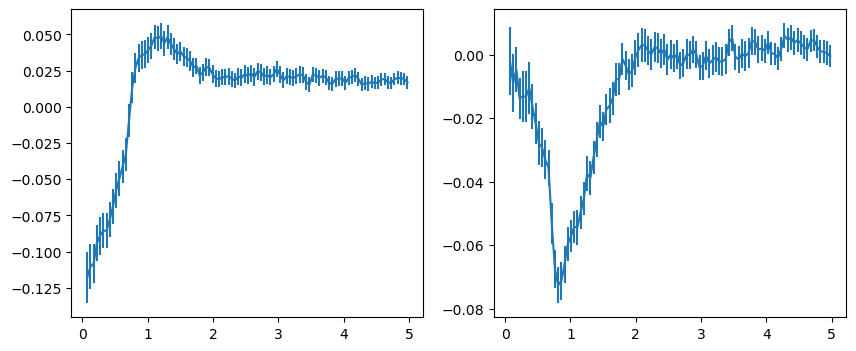

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.errorbar(MICE['R'], MICE['Sigma'], np.sqrt(np.diag(MICE['covS'])))
ax2.errorbar(MICE['R'], MICE['DSigma_t'], np.sqrt(np.diag(MICE['covDSt'])))

Text(0.5, 1.0, '$\\Sigma_c \\gamma_{\\times}$')

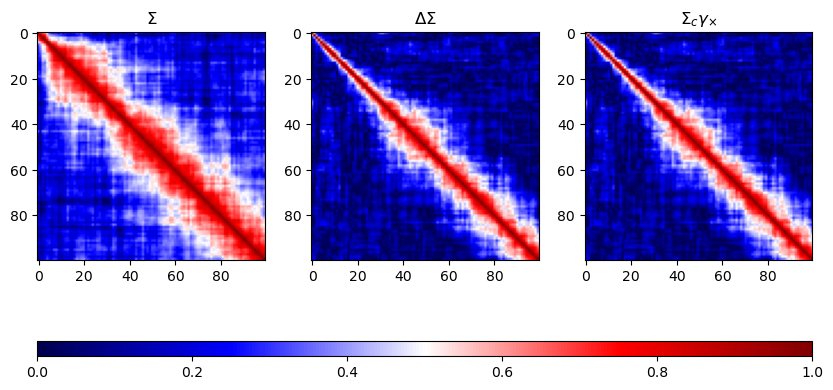

In [40]:
#colormap = 'RdYlGn_r'
colormap = 'seismic'
fig, axes = plt.subplots(1,3,figsize=(10,7), sharex=True)
cmp = axes[0].imshow(normalize_cov(np.abs(MICE['covS'])), vmin=0, vmax=1, cmap=colormap)
axes[1].imshow(normalize_cov(np.abs(MICE['covDSt'])), vmin=0, vmax=1, cmap=colormap)
axes[2].imshow(normalize_cov(np.abs(MICE['covDSx'])), vmin=0, vmax=1, cmap=colormap)
fig.colorbar(cmp, location='bottom', ax=axes, aspect=50)

axes[0].set_title('$\Sigma$')
axes[1].set_title('$\Delta \Sigma$')
axes[2].set_title('$\Sigma_c \gamma_{\\times}$')

In [ ]:
#colormap = 'RdYlGn_r'
colormap = 'seismic'
fig, axes = plt.subplots(1,3,figsize=(10,7), sharex=True)
cmp = axes[0].imshow(normalize_cov(np.linalg.inv(MICE['covS'])), cmap=colormap)
axes[1].imshow(normalize_cov(np.linalg.inv(MICE['covDSt'])), cmap=colormap)
axes[2].imshow(normalize_cov(np.linalg.inv(MICE['covDSx'])), cmap=colormap)
fig.colorbar(cmp, location='bottom', ax=axes, aspect=50)

axes[0].set_title('$\Sigma$')
axes[1].set_title('$\Delta \Sigma$')
axes[2].set_title('$\Sigma_c \gamma_{\\times}$')

In [ ]:
pos_mlw = np.array([
    np.random.uniform(0.85,1.5,NWalkers),
    np.random.uniform(-0.9,-0.1,NWalkers),
    np.random.uniform(-0.8,0.5,NWalkers),
    #np.random.uniform(4.5,9.0,nwalkers),
    np.random.uniform(-0.1,0.1,NWalkers),
]).T

pos_hsw = np.array([
    np.random.uniform(-0.9,-0.1,NWalkers),
    np.random.uniform(0.9,1.8,NWalkers),
    np.random.uniform(2.5,4.0,NWalkers),
    np.random.uniform(5.0,10.0,NWalkers),
    np.random.uniform(-0.45,0.45,NWalkers),
]).T

pos_hswf = np.array([
    #np.random.uniform(-0.9,-0.1,NWalkers),
    np.random.uniform(0.5,1.8,NWalkers),
    #np.random.uniform(1.0,9.0,NWalkers),
    #np.random.uniform(3.0,14.0,NWalkers),
    np.random.uniform(-0.45,0.45,NWalkers),
]).T

In [ ]:
#model = HSW()
model = HSWfixed()

#model = ModLW()
#model = modifiedLW()

start=0

logL1 = Likelihood(
    func=model.sigma,
    r=MICE['R'],
    y=MICE['Sigma'],
    yerr=np.sqrt(np.diag(MICE['covS'])),
    #yerr=np.linalg.inv(MICE['covS']),
    limits=model.limits_S,
    redshift=MICE['MEANZ']
)
logL2 = Likelihood(
    func=model.delta_sigma,
    r=MICE['R'],
    y=MICE['Sigma'],
    yerr=np.sqrt(np.diag(MICE['covDSt'])),
    #yerr=np.linalg.inv(MICE['covDSt']),
    limits=model.limits_S,
    redshift=MICE['MEANZ']
)

def sum_logL(theta):
    return logL1.log_probability(theta)+logL2.log_probability(theta)
    
with Pool(processes=NCORES) as pool:
    sampler = emcee.EnsembleSampler(
        NWalkers,
        len(logL1.params),
        #logL.log_probability,
        sum_logL,
        pool=pool
    )
    sampler.run_mcmc(
        #pos_mlw, 
        #pos_hsw, 
        pos_hswf, 
        NIT, progress=True
    )

MICE['fitted_params'] = {}
MICE['error_params'] = {}
MICE['mcmc_samples'] = sampler.get_chain()
MICE['sampler_dict'] = sampler
    

In [ ]:
for i,param in enumerate(logL1.params):
    percentil = np.percentile(MICE['mcmc_samples'][int(NIT*0.5),:,i], [16,50,84])
    MICE['fitted_params'][param] = percentil[1]
    MICE['error_params'][param] = tuple(percentil[[0,2]]-percentil[1])

red_chisq = chi_red(logL1.func(logL1.r, *MICE['fitted_params'].values())*logL1.rhomean, logL1.y, logL1.yerr, len(logL1.params))
print('Reduced chi: '.ljust(10,'.'), red_chisq)
red_chisq = chi_red(logL2.func(logL2.r, *MICE['fitted_params'].values())*logL2.rhomean, logL2.y, logL2.yerr, len(logL2.params))
print('Reduced chi: '.ljust(10,'.'), red_chisq)

In [ ]:
axes = plot_chains(len(logL1.params), MICE['sampler_dict'], color='darkgreen')

In [ ]:
fig = plot_mcmc_contours(len(logL1.params), MICE['sampler_dict'], trow=0.8, color='darkgreen')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharex=True)

ax1.errorbar(MICE['R'], MICE['Sigma'], np.sqrt(np.diag(MICE['covS'])), fmt='.', capsize=2, color='darkgreen')
#ax1.plot(R[g][z][t][start:], Sigma[g][z][t][start:], '.--')
ax1.plot(logL1.r, logL1.func(MICE['R'], *MICE['fitted_params'].values())*rho_mean(MICE['MEANZ']))

ax2.errorbar(MICE['R'], MICE['DSigma_t'], np.sqrt(np.diag(MICE['covDSt'])), fmt='.', capsize=2, color='darkgreen')
#ax1.plot(R[g][z][t][start:], DSigma_t[g][z][t][start:], '.--')
ax2.plot(logL2.r, logL2.func(MICE['R'], *MICE['fitted_params'].values())*rho_mean(MICE['MEANZ']))